In [ ]:
!pip install transformers
!pip install torchtext==0.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.7 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [ ]:
from torchtext.data import Field, TabularDataset, BucketIterator,LabelField
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [ ]:
print(torch.version.cuda)
print(torch.__version__)
import sys
print(sys.version)
print(np.__version__)
print(pd.__version__)


11.8
2.0.1+cu118
3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
1.23.5
1.5.3


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)


init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

[CLS] [SEP] [PAD] [UNK]
101 102 0 100
101 102 0 100


In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
print(max_input_length)

512


In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    return tokens

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the original dataset
df = pd.read_csv('missom_annotated.csv')
df = df.rename(columns={'label_minority_stress': 'label'})
df = df[['text', 'label']]

empty_cells =  df.isnull().sum()
print(empty_cells)
df.dropna(inplace = True)

empty_cells =  df.isnull().sum()
print(empty_cells)


text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

train_ratio = 0.70
valid_ratio = 0.15
test_ratio = 0.15

train_df, remaining_df = train_test_split(df, test_size=1 - train_ratio, random_state=random.seed(SEED))
valid_df, test_df = train_test_split(remaining_df, test_size=test_ratio/(valid_ratio + test_ratio), random_state=random.seed(SEED))

# Save the dataframes to CSV files
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
valid_df.to_csv('valid.csv', index=False)

In [ ]:
TEXT = Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = LabelField(dtype = torch.float)

In [ ]:
# Load the data
train_data,valid_data, test_data = TabularDataset.splits(
    path= '/content/',
    train='train.csv',
    validation='valid.csv',
    test='test.csv',
    format='csv',
    fields=[('text', TEXT), ('label', LABEL)],
    skip_header=True
)
print('Number of training examples: {}'.format(len(train_data)))
print('Number of Validation examples: {}'.format(len(valid_data)))
print('Number of testing examples: {}'.format(len(test_data)))
print(train_data[0])

Number of training examples: 4052
Number of Validation examples: 868
Number of testing examples: 869


In [ ]:

TEXT.build_vocab(train_data, min_freq=1)

LABEL.build_vocab(train_data)

In [ ]:
BATCH_SIZE = 32
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=lambda x: len(x.text),
    sort_within_batch = True
    )

In [ ]:
from transformers import BertTokenizer, BertModel
bert = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self,bert, vocab_size, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):
        super().__init__()
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1,
                                              out_channels = n_filters,
                                              kernel_size = (fs, embedding_dim))
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        with torch.no_grad():
            embedded = self.bert(text)[0]
        embedded = embedded.unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim = 1))
        return self.fc(cat)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN(bert,INPUT_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

model = model.to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 120,062,041 trainable parameters


In [ ]:
for name, param in model.named_parameters():
    if name.startswith('bert'):
        param.requires_grad = False

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text = batch.text
        predictions = model(text)
        loss = criterion(predictions, batch.label.unsqueeze(1))
        acc = binary_accuracy(predictions, batch.label.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text = batch.text
            predictions = model(text)
            loss = criterion(predictions, batch.label.unsqueeze(1))
            acc = binary_accuracy(predictions, batch.label.unsqueeze(1))
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 01 | Epoch Time: 1m 0s
	Train Loss: 0.496 | Train Acc: 79.07%
	 Val. Loss: 0.469 |  Val. Acc: 79.80%
Epoch: 02 | Epoch Time: 0m 56s
	Train Loss: 0.386 | Train Acc: 82.86%
	 Val. Loss: 0.369 |  Val. Acc: 83.48%
Epoch: 03 | Epoch Time: 1m 0s
	Train Loss: 0.356 | Train Acc: 84.71%
	 Val. Loss: 0.430 |  Val. Acc: 82.03%
Epoch: 04 | Epoch Time: 0m 59s
	Train Loss: 0.334 | Train Acc: 85.72%
	 Val. Loss: 0.355 |  Val. Acc: 84.71%
Epoch: 05 | Epoch Time: 1m 0s
	Train Loss: 0.295 | Train Acc: 87.04%
	 Val. Loss: 0.446 |  Val. Acc: 81.47%
Epoch: 06 | Epoch Time: 0m 59s
	Train Loss: 0.283 | Train Acc: 88.36%
	 Val. Loss: 0.388 |  Val. Acc: 82.92%
Epoch: 07 | Epoch Time: 1m 0s
	Train Loss: 0.255 | Train Acc: 89.78%
	 Val. Loss: 0.402 |  Val. Acc: 84.15%
Epoch: 08 | Epoch Time: 1m 0s
	Train Loss: 0.229 | Train Acc: 90.86%
	 Val. Loss: 0.412 |  Val. Acc: 84.82%
Epoch: 09 | Epoch Time: 0m 59s
	Train Loss: 0.195 | Train Acc: 91.96%
	 Val. Loss: 0.470 |  Val. Acc: 83.82%
Epoch: 10 | Epoch Time: 

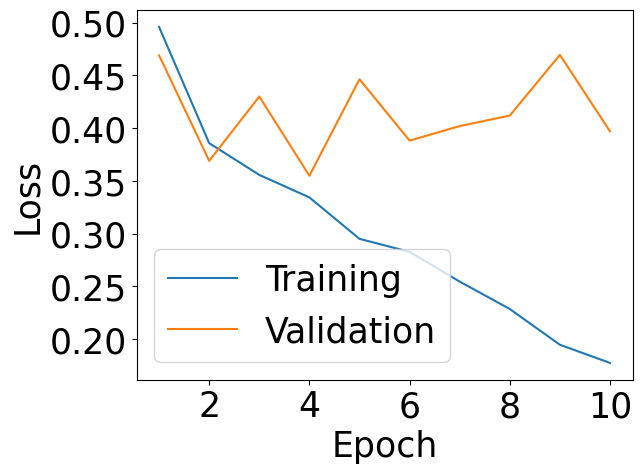

In [ ]:
epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, train_losses, label='Training')
plt.plot(epochs, valid_losses, label='Validation')
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Loss', fontsize=25)

# Increase the font size of x and y tick labels
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.legend(fontsize=25)
plt.show()

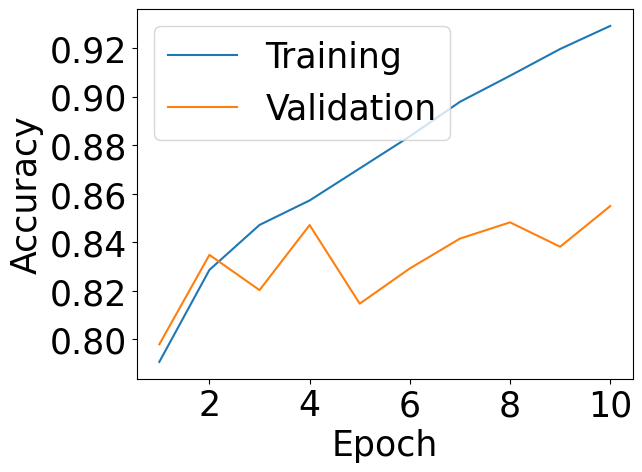

In [ ]:
epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, train_accuracies, label='Training')
plt.plot(epochs, valid_accuracies, label='Validation')
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Accuracy',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
def calc_report(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    y_pred = []
    y_true = []

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            text = batch.text
            predictions = model(text)

            threshold = 0.5
            output_1 = (predictions > threshold).int()
            y_pred.extend(output_1.tolist())
            y_true.extend(batch.label.tolist())

            loss = criterion(predictions, batch.label.unsqueeze(1))
            acc = binary_accuracy(predictions, batch.label.unsqueeze(1))

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            rep = classification_report(y_true, y_pred, labels=[1,0], digits=2)

    return rep





In [ ]:
cal = calc_report(model, test_iterator, criterion)
print(cal)

              precision    recall  f1-score   support

           1       0.72      0.45      0.56       173
           0       0.88      0.96      0.91       696

    accuracy                           0.86       869
   macro avg       0.80      0.70      0.73       869
weighted avg       0.84      0.86      0.84       869



Reference for this code is below to this link.


https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb